In [1]:
import gym
import MCTSnet
import copy
import torch
from importlib import reload
from IPython import display
import time
import PIL
import copy
import marshal
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Testing environment

In [2]:
env = gym.make("SokobanEnc-v0")

In [3]:
len(env.solution)

102

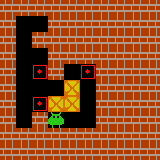

In [4]:
env.render()

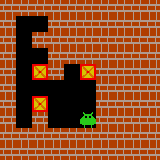

In [5]:
test = []
n_env = copy.deepcopy(env)
for k in reversed(n_env.solution):
    display.clear_output(wait=True)
    res = n_env.step(k)
    display.display(n_env.render())
    time.sleep(0.05)
    test.append(marshal.dumps(res[0]))

In [6]:
len(list(set(test)))

102

# Testing the four neural networks

In [7]:
e = MCTSnet.models.embedding.Epsilon()

In [8]:
state = torch.Tensor(res[0]).to(device)
state.reshape((-1,4,10,10)).shape

torch.Size([1, 4, 10, 10])

In [9]:
embed = e.forward(state.reshape((-1, 4, 10, 10)))

In [10]:
reward = torch.tensor([res[1]], requires_grad=True).to(device)
action = torch.tensor([3.], requires_grad=True).to(device)

In [11]:
b = MCTSnet.models.backup.BetaMLP()

In [12]:
h_s = b(embed, embed, reward.reshape((-1, 1)), action.reshape((-1, 1)))

In [13]:
r = MCTSnet.models.readout.Rho()

In [14]:
r(h_s)

tensor([[0.1427, 0.1450, 0.1329, 0.1042, 0.1006, 0.1316, 0.1220, 0.1210]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [34]:
pi = MCTSnet.models.policy.randomPi()
actions = pi(torch.cat((h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s), dim=0).reshape(-1, 9, 128))

In [35]:
actions

tensor([[0.7898, 0.8604, 0.6761, 0.4712, 0.4879, 0.6919, 0.7295, 0.0829]],
       dtype=torch.float64)

In [36]:
torch.argmax(actions)

tensor(1)

In [37]:
state.shape

torch.Size([4, 10, 10])

# Testing the full MCTSnet

In [40]:
reload(MCTSnet.memory.maze)
reload(MCTSnet.memory)
reload(MCTSnet.models.MCTSnet)

<module 'MCTSnet.models.MCTSnet' from 'F:\\Projets\\MCTSnet\\MCTSnet\\models\\MCTSnet.py'>

In [41]:
m_net = MCTSnet.models.MCTSnet.MCTSnet(b, e, pi, r)
m_net.env = env
m_net.reset_tree(state.reshape((-1, 4, 10, 10)))
prediction = m_net(state.reshape((-1, 4, 10, 10)).to(device))

In [42]:
prediction

tensor([[0.1283, 0.1271, 0.1237, 0.1199, 0.1136, 0.1352, 0.1274, 0.1247]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [43]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(m_net.parameters(), lr=0.0001)

### Checking that gradients are computed (is the model differentiable ?)

In [44]:
optimizer.zero_grad()
loss = criterion(prediction, torch.tensor([[1.,0.,0.,0.,0.,0.,0.,0.]]).to(device))
loss.backward()

In [45]:
m_net.backup.fc1.weight.grad

tensor([[ 5.4700e-05, -1.4760e-09, -7.9938e-06,  ..., -8.7007e-09,
          2.5563e-04, -6.1789e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -0.0000e+00,  0.0000e+00],
        [-3.6515e-07, -7.9912e-07, -7.2803e-09,  ..., -1.2280e-08,
         -7.2119e-06, -4.7485e-05],
        ...,
        [-7.7050e-06,  2.2128e-09,  0.0000e+00,  ...,  0.0000e+00,
          2.4296e-05,  0.0000e+00],
        [-6.4327e-05, -3.1960e-07, -4.0074e-06,  ...,  1.9535e-08,
         -6.3018e-05,  1.1556e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -3.2348e-07,  0.0000e+00]], device='cuda:0')

In [46]:
m_net.embedding.input.weight.grad

tensor([[[[-1.0372e-06, -2.2035e-06, -1.3931e-06],
          [-2.6383e-06, -3.8248e-06, -3.8858e-06],
          [-3.7126e-06, -5.6735e-06, -4.7376e-06]],

         [[-3.4174e-07, -4.0296e-07, -3.8513e-07],
          [-2.0798e-07, -4.6167e-07,  0.0000e+00],
          [ 1.7256e-07, -4.0988e-07,  7.1241e-07]],

         [[ 1.5778e-07,  5.7113e-07,  0.0000e+00],
          [ 1.1309e-06,  3.2969e-07,  0.0000e+00],
          [-5.3004e-07,  2.1950e-07,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]],


        [[[-8.6662e-07, -2.6114e-06, -2.5883e-08],
          [-2.3779e-06, -6.0239e-07,  1.6899e-06],
          [-6.3630e-07, -1.1896e-07,  8.1090e-07]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-8.3061e-07,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  2.2701e-07,  0.0000e+00],
          [-8.501

as "expected" the policy doesn't learn and may require additionnal work

In [47]:
m_net.policy.piL.fc1.weight.grad.min()

AttributeError: 'randomPi' object has no attribute 'piL'

In [48]:
m_net.readout.fc1.weight.grad

tensor([[-7.7370e-05, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
         -1.0349e-02, -0.0000e+00],
        [ 1.1313e-05,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          1.5133e-03,  0.0000e+00],
        [ 1.0968e-05,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          1.4671e-03,  0.0000e+00],
        ...,
        [ 1.2143e-05,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          1.6242e-03,  0.0000e+00],
        [ 1.1342e-05,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          1.5171e-03,  0.0000e+00],
        [ 1.1065e-05,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          1.4800e-03,  0.0000e+00]], device='cuda:0')

In [49]:
m_net.state_dict

<bound method Module.state_dict of MCTSnet(
  (backup): BetaMLP(
    (fc1): Linear(in_features=258, out_features=128, bias=True)
  )
  (embedding): Epsilon(
    (input): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (final): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (out): Linear(in_features=3200, out_features=128, bias=True)
  )
  (policy): randomPi(
    (out): Linear(in_features=8, out_features=1, bias=True)
  )
  (readout): Rho(
    (fc1): Linear(in_features=128, out_features=8, bias=True)
  )
)>

# Trainer

In [28]:
reload(MCTSnet.trainer)
reload(MCTSnet)
sokoban = MCTSnet.MCTSnetSokoban((4, 10, 10), n_embeddings=128, n_actions=4, n_simulations=10)

In [29]:
# sokoban.train(500)

# Attempt at Mouse game

Here we attempt to train the model to imitate a very basic MCTS. More precisely the net must guess the expectation of each action based on the explored graph.

In [88]:
reload(MCTSnet.memory.tree)
reload(MCTSnet.memory.maze)
reload(MCTSnet.memory)
reload(MCTSnet.trainer)
reload(MCTSnet.models.readout)
reload(MCTSnet.models.backup)
reload(MCTSnet.models.embedding)
reload(MCTSnet.models.MCTSnet)
reload(MCTSnet.mouse.game)
reload(MCTSnet.mouse.solver)
env = MCTSnet.mouse.game.EnvironmentExploring()

bleu +10, jaune -10

In [89]:
state = env.reset()

In [90]:
state.shape

(2, 10, 10)

In [91]:
mnet = MCTSnet.trainer.MCTSnetMouse(n_simulations=15)

In [92]:
# mnet.build_training_set(1000, 100)

In [93]:
mnet.load_training_set("data/mouse_1000_100")

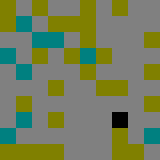

40.0

In [45]:
mnet.play_solution(1, max_steps=100)

In [ ]:
mnet.optimizer = torch.optim.Adam(mnet.model.parameters(), lr=0.0001)
mnet.train(400, 100, offset=0)  # 21h

[1,    99] mean loss: 1.337
[1,   199] mean loss: 1.370
[1,   299] mean loss: 1.370
[1,   399] mean loss: 1.319
[1,   499] mean loss: 1.304
[1,   599] mean loss: 1.356
[1,   699] mean loss: 1.327
[1,   799] mean loss: 1.380
[1,   899] mean loss: 1.302
[1,   999] mean loss: 1.363
[1,  1099] mean loss: 1.303
[1,  1199] mean loss: 1.331
[1,  1299] mean loss: 1.326
[1,  1399] mean loss: 1.328
[1,  1499] mean loss: 1.365
[1,  1599] mean loss: 1.295
[1,  1699] mean loss: 1.352
[1,  1799] mean loss: 1.358
[1,  1899] mean loss: 1.314
[1,  1999] mean loss: 1.365
[1,  2099] mean loss: 1.307
[1,  2199] mean loss: 1.359
[1,  2299] mean loss: 1.386
[1,  2399] mean loss: 1.341
[1,  2499] mean loss: 1.303
[1,  2599] mean loss: 1.294
[1,  2699] mean loss: 1.354
[1,  2799] mean loss: 1.318
[1,  2899] mean loss: 1.366
[1,  2999] mean loss: 1.356
[1,  3099] mean loss: 1.329
[1,  3199] mean loss: 1.349
[1,  3299] mean loss: 1.344
[1,  3399] mean loss: 1.366
[1,  3499] mean loss: 1.346
[1,  3599] mean loss

In [78]:
mnet.save_weights("mnet_400_100_227k")

In [8]:
mnet2 = MCTSnet.trainer.MCTSnetMouse(n_simulations=15)

In [94]:
mnet.load_weights("mnet_400_100_227k")

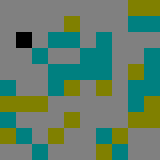

-90.0

In [103]:
mnet.play(478, max_steps=100)

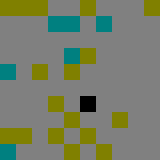

40.0

In [57]:
mnet2.play_solution(2, max_steps=100)